## Idea of the Repository: (Work in Progress)

The idea of the blog/repository is to:

1) Explore PCA for text visualizations -- words, sentences, documents.

2) Understand how using PCA helps improve text classification.

3) Explore the Spotify Annoy library and test the text classification improvement using the same.

4) (Optional) Explore the TSNE library for visualization and insights -- words, sentences, documents, text classification outputs.

## Importing Required Libraries

In [54]:
import os
import re
import math
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.util import ngrams
from functools import reduce
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

## Exploring the Data

In [55]:
train = fetch_20newsgroups(subset="train") 
test = fetch_20newsgroups(subset="test")

In [57]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [58]:
X_train = train["data"]
X_test = test["data"]
y_train = train["target"] 
y_test = test["target"]

In [59]:
df_train = pd.DataFrame(X_train, columns=['message'])

In [60]:
df_train['target'] = y_train

In [61]:
df_train.head()

,message,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [62]:
df_test = pd.DataFrame(X_test, columns = ['message'])
df_test['target'] = y_test

In [63]:
y_train = df_train['target']

In [64]:
df_train['message'].iloc[1]

"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n"

In [65]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])'," ", text)
    return text

In [66]:
df_train['cleaned_message'] = df_train['message'].apply(lambda x: clean_text(x))

In [67]:
df_train.head()

,message,target,cleaned_message
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,from lerxst umd edu where s my thing subje...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,from guykuo u washington edu guy kuo subje...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,from twillis ecn purdue edu thomas e willis...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,from jgreen joe green subject re weitek ...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,from jcm cfa harvard edu jonathan mcdowell ...


In [68]:
df_train['len'] = df_train['cleaned_message'].apply(lambda x:len(x))

In [69]:
df_train.head()

,message,target,cleaned_message,len
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,from lerxst umd edu where s my thing subje...,718
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,from guykuo u washington edu guy kuo subje...,851
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,from twillis ecn purdue edu thomas e willis...,1976
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,from jgreen joe green subject re weitek ...,790
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,from jcm cfa harvard edu jonathan mcdowell ...,1098


In [134]:
from gensim.models import Word2Vec
tokens = [nltk.word_tokenize(words) for words in df_train['cleaned_message'][0:2]]
model = Word2Vec(tokens,size=50,sg=1,min_count=1)

In [135]:
print(tokens[0])

['from', 'lerxst', 'umd', 'edu', 'where', 's', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac3', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', '15', 'i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', 'it', 'was', 'a', '2', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', 'early', '70s', 'it', 'was', 'called', 'a', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'i', 'know', 'if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'e', 'mail', 'thanks', 'il', 'broug

In [136]:
words=list(model.wv.vocab)
print(words)

['from', 'lerxst', 'umd', 'edu', 'where', 's', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac3', 'wam', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', '15', 'i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'saw', 'the', 'other', 'day', 'it', 'a', '2', 'door', 'sports', 'looked', 'to', 'be', 'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors', 'were', 'really', 'small', 'in', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'all', 'know', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'funky', 'looking', 'please', 'e', 'mail', 'thanks', 'il', 'brought', 'by', 'your', 'neighborhood', 'guykuo', 'u', 'washington', 'guy', 'kuo', 'si', 'clock', 'poll', 'final', 'call', 'summary', 'for', 'reports', 'keywords', 'acceleration', 'upgrade', 'article', 'd', 'shelley', '1qvfo9innc3s'

In [137]:
X=model[model.wv.vocab]
df=pd.DataFrame(X)
df.shape
df.head()

/home/faizan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.009989,0.004815,0.004198,0.004412,0.009330,0.007133,-0.003564,-0.005750,-0.002749,0.004432,...,0.005346,0.009430,-0.004300,-0.005136,0.005451,-0.001719,0.007762,0.000237,-0.000652,-0.003665
1,0.005860,0.002035,0.001081,-0.001575,-0.002118,0.009427,-0.007995,0.002575,-0.005749,-0.004265,...,-0.008569,-0.007516,0.003275,0.006578,0.005648,-0.002565,-0.003419,0.007483,0.003036,-0.002221
2,-0.005434,-0.001019,0.005429,-0.003852,-0.008293,-0.006689,-0.008497,0.003338,0.002787,-0.007812,...,-0.006771,0.000722,-0.009530,0.006312,0.006278,0.000020,0.000134,-0.004110,0.003769,-0.007478
3,-0.009682,-0.003035,-0.008217,-0.005283,0.008222,0.004890,0.001706,-0.008095,-0.009493,-0.002188,...,-0.007001,-0.004944,0.010000,0.008304,0.003084,0.000673,0.000616,-0.008937,-0.009456,0.004461
4,0.003036,-0.008764,-0.008309,0.001128,-0.001560,0.007496,0.006619,-0.007461,0.006596,-0.007209,...,0.004050,0.000854,-0.001864,-0.006188,-0.008889,0.002540,-0.007037,0.009701,0.004705,0.004742


In [138]:
#Computing the correlation matrix
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
new_X=np.dot(X,new_vectors)

In [139]:
new_X

array([[-4.08604497e-03,  5.59975367e-03],
       [-1.41327652e-03,  1.65626636e-03],
       [-2.87042801e-03,  9.58669509e-03],
       [ 3.36688340e-04,  4.87566267e-03],
       [ 1.84245500e-02,  2.31150580e-03],
       [ 9.66404341e-03,  5.57039410e-04],
       [-1.41551814e-02,  5.87570612e-03],
       [-2.37397446e-03, -8.76750736e-03],
       [ 2.67895094e-03, -1.32308804e-03],
       [-1.31230281e-02, -1.34732625e-02],
       [-4.98180630e-03, -4.87862400e-03],
       [-8.35165628e-03,  4.55237454e-03],
       [ 9.32985526e-03, -5.40306107e-03],
       [ 1.08986946e-02,  8.54208884e-03],
       [-1.03374875e-02,  2.01329486e-03],
       [ 5.20377605e-03, -1.00693937e-02],
       [-1.20351050e-03,  2.54059901e-03],
       [ 1.81776844e-02,  4.37965621e-03],
       [ 3.13088013e-03,  2.64672240e-03],
       [ 2.30257285e-03,  9.28454177e-03],
       [-1.56089815e-03,  9.28857735e-03],
       [-5.12757198e-03,  6.58628435e-03],
       [-5.85277914e-03, -2.16252787e-03],
       [ 5.

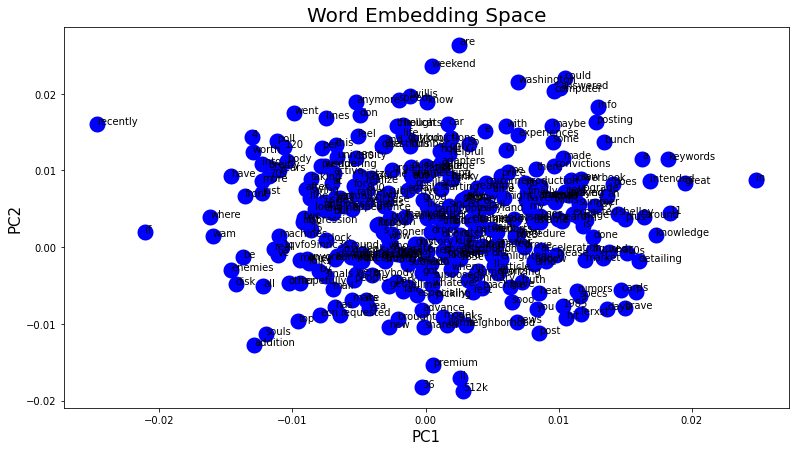

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(new_X[:,0],new_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(model.wv.vocab)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(new_X[i,0],new_X[i,1]))

tf_idf = TfidfVectorizer()
X_train_tfidf = tf_idf.fit_transform(df_train['cleaned_message'][0:2000])

In [19]:
X_train_tfidf.toarray().shape

(2000, 50919)

In [20]:
clf = MultinomialNB().fit(X_train_tfidf, y_train[0:2000])

In [21]:
X_test_vectors = tf_idf.transform(X_test)

In [22]:
y_pred = clf.predict(X_test_vectors)

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.18      0.84      0.30        69
           1       0.20      0.92      0.33        84
           2       0.61      0.58      0.59       414
           3       0.44      0.78      0.57       223
           4       0.64      0.69      0.66       360
           5       0.38      0.91      0.53       163
           6       0.55      0.91      0.69       235
           7       0.79      0.77      0.78       405
           8       0.73      0.87      0.79       331
           9       0.66      0.94      0.77       277
          10       0.90      0.90      0.90       400
          11       0.88      0.65      0.75       533
          12       0.34      0.68      0.45       197
          13       0.23      0.93      0.37        99
          14       0.34      0.96      0.50       137
          15       1.00      0.13      0.24      2943
          16       0.69      0.65      0.67       387
          17       0.59    

In [25]:
from sklearn import decomposition
pca = decomposition.PCA()

In [35]:
pca.n_components = 5
pca_data = pca.fit_transform(X_train_tfidf.toarray())

In [36]:
# vectorizer = CountVectorizer(ngram_range=(2,2))

# file=open('data/test.ft.txt','r',encoding="utf-8")

# g=file.read()

# sentences=sent_tokenize(g)
# # 
# wn=WordNetLemmatizer()

In [37]:
pca_data

array([[ 0.01630973,  0.00962476,  0.01366958,  0.05842661, -0.02447871],
       [-0.10185021,  0.03445126,  0.00330599, -0.00098787, -0.05460964],
       [ 0.14284151,  0.04772588,  0.09522157,  0.06351282, -0.03664118],
       ...,
       [ 0.02630876,  0.01748979,  0.0348674 ,  0.03161009, -0.01123154],
       [ 0.12509368,  0.02083381, -0.0438796 , -0.08120415,  0.0263171 ],
       [ 0.12223218, -0.16387152, -0.10882049, -0.04351209, -0.0858884 ]])

In [45]:
pca_df = pd.DataFrame(pca_data, columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])

In [52]:
pca_df['target'] = y_train[0:2000]

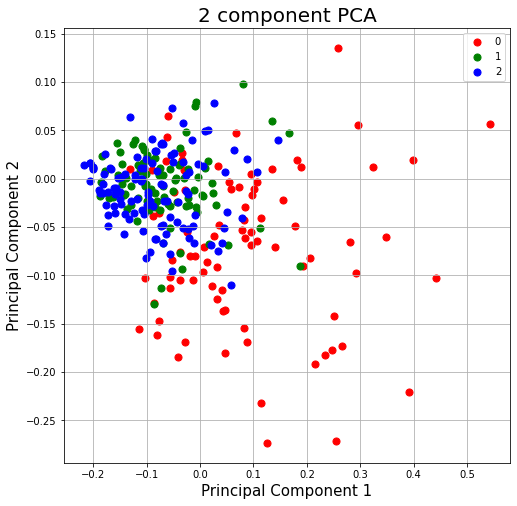

In [53]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']
targets = list(set(y_train[0:2000]))
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['target'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:

# def preprocess_text(text):
#     tokens = word_tokenize(text)
#     stop_words=stopwords.words('english')
#     stop_words.extend(['__label__1','__label__2'])
#     tokens=[token.lower() for token in tokens if token not in stop_words]
#     tokens=[re.sub(r'[^A-Za-z]+','',token) for token in tokens]
#     tokens=[wn.lemmatize(token) for token in tokens]
#     return tokens  


# text_tokens=[]
# for item in sentences[0:1000]:
#     tokens = preprocess_text(item)
#     temp = " ".join(tokens)
#     text_tokens.append(temp)    



# word_dist = FreqDist()
# for s in text_tokens:
#     word_dist.update(s.split())

# ########################################################################################



# text=''
# for sent in text_tokens:
#     text=text+sent

# tokens=word_tokenize(text)    
# bigrams = ngrams(tokens,2)

# bigram_dict=dict(Counter(bigrams))

# final_bigram_dict={}
# for key,value in bigram_dict.items():
#     new_key=" ".join(key)
#     final_bigram_dict[new_key]=value

# unigram_index= CountVectorizer(ngram_range=(1,1))
# unigram_index.fit_transform(text_tokens)
# unigram_dist = unigram_index.vocabulary_


# def pmi(word1, word2 ,unigram_freq, bigram_freq):
#     #print(word1,word2)
#     prob_word1 = unigram_freq[word1]/float(sum(unigram_freq.values()))
#     #print(prob_word1)
#     prob_word2 = unigram_freq[word2]/float(sum(unigram_freq.values()))
#     #print(prob_word2)
#     prob_word1_word2 = bigram_freq[" ".join([word1,word2])]/float(sum(bigram_freq.values()))
#     #print(prob_word1_word2)
#     ratio = prob_word1_word2/float(prob_word1*prob_word2)
#     #print(word1,word2,prob_word1,prob_word2)
#     if ratio==0:
#         return 0
#     else:
#         return math.log(ratio,2)

# pmi_dict={}
# for key in final_bigram_dict.keys():
#     first_word = key.split()[0]
#     second_word = key.split()[1]
#     if (first_word in word_dist.keys()) and (second_word in word_dist.keys()):
#         pmi_dict[key]=pmi(key.split()[0],key.split()[1],word_dist,final_bigram_dict)
#     else:
#         pmi_dict[key]=0


# start = '\s'
# end= '\e'

    
# context_word_pairs={}
# for story_id in range(0,len(text_tokens)):
#     text_tokens[story_id] = start +' '+ text_tokens[story_id] +' '+ end
#     list_of_words=text_tokens[story_id].split()
#     context_word_pairs[story_id] = {}
#     for word_index in range(1,len(list_of_words)-1):
#         context_word_pairs[story_id][list_of_words[word_index]]=[list_of_words[word_index-1],list_of_words[word_index+1]]
# #    
# #tokens=[]
# #for s in text_tokens:
# #    tokens.extend(word_tokenize(s))
# #
# #unique_words=set(tokens)
# #
# list_cw_pairs=[]
# for i in range(0,len(context_word_pairs)):
#     list_cw_pairs.append(context_word_pairs[i])
# #
# #for word in unique_words:
# #    print(context_word_pairs.get(word))
    


# def foo(r, d):
#     for k in d:
#         r[k].append(d[k])
    
# d = reduce(lambda r, d: foo(r, d) or r, list_cw_pairs, defaultdict(list))    
    
    
# final_dict={}
# for k,v in d.items():
#     tmp_list_before=[]
#     tmp_list_after=[]
#     for x in range(0,len(v)):
#         tmp_list_before.append(v[x][0])
#         tmp_list_after.append(v[x][1])
#     final_dict[k]=[tmp_list_before,tmp_list_after]
    
# def create_vectors(word,context):
#     #print(word)
#     #print(context)
#     vector = np.zeros((len(word_dist.keys()),)) 
#     for x in range(0,len(context[0])):
#         temp_word_1 = context[0][x]+" " + word
#         if temp_word_1 in pmi_dict.keys():
#             vector[word_dist[context[0][x]]] = pmi_dict[temp_word_1]
#     for y in range(0,len(context[1])):
#         temp_word_2 = word + " " + context[1][y]
#         if temp_word_2 in pmi_dict.keys():
#             vector[word_dist[context[1][y]]] = pmi_dict[temp_word_2]
#     return vector

# word_vectors=[]
# word_list=[]
# for w,v in final_dict.items():
#     if w!="":
#         word_vectors.append(create_vectors(w,v))
#         word_list.append(w)
 
 
        
        


# pca=PCA(n_components=300)

# principalComponents=pca.fit_transform(word_vectors)

# '''
# new_pca = PCA(n_components = 2)
# n=new_pca.fit_transform(principalComponents)
# plt.scatter(n[:,0],n[:,1])

# for i,word in enumerate(word_list[0:300]):
#     plt.annotate(word,xy=(n[i,0],n[i,1]))
# plt.show()

# '''
# labels = []
# tokens = []

# for word in range(0,len(word_list)):
#     tokens.append(word_vectors[word])
#     labels.append(word_list[word])

# tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
# new_values = tsne_model.fit_transform(tokens)

# x = []
# y = []
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])
    
# plt.figure(figsize=(16, 16)) 
# for i in range(len(x)):
#     plt.scatter(x[i],y[i])
#     plt.annotate(labels[i],
#                  xy=(x[i], y[i]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')
# plt.show()
# '''
# from annoy import AnnoyIndex

# num=300
# t = AnnoyIndex(num)

# for i in range(0,len(principalComponents)):
#     t.add_item(i,principalComponents[i])
    
# t.build(10)
    
# print(word_list[0])
# #print(t.get_nns_by_item(0,5))
# for i in t.get_nns_by_item(0,5):
#     print(word_list[i])
# #print(t.get_distance(1,4))

# #print(t.get_distance(18,24))
